<a href="https://colab.research.google.com/github/acedesci/scanalytics/blob/master/S11_disruption_management/S11_Module1A_Disruption_Cost_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install Pyomo and GLPK
!pip install -q pyomo
!apt-get install -y -qq glpk-utils #if GLPK is used
# !apt-get install -y -qq coinor-cbc #if cbc is used

     |████████████████████████████████| 2.4MB 2.8MB/s 
     |████████████████████████████████| 256kB 21.9MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 163kB 21.8MB/s 
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 134443 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_4.65-1_amd64.deb ...
Unpacking libglpk40:amd64 (4.65-1) ...
Selecting previously unselected package glpk-

In [108]:
from google.colab import drive
drive.mount('/content/drive')
cwd = '/content/drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [169]:
import pandas
from pyomo.environ import *

inputScenarios = pandas.read_csv(cwd +'inputScenarios_Prob2_ConfC.csv')
inputParameters = pandas.read_csv(cwd +'inputParameters_Prob2.csv')

print(inputScenarios)
print(inputParameters)

productList = inputParameters.loc[inputParameters['Type']=='Product']['Index'].unique()
supplierList = inputParameters.loc[inputParameters['Type']=='Supplier']['Index'].unique()
scenarioList = inputParameters.loc[inputParameters['Type']=='Disruption']['Index'].unique()


supplierCapacityDict = {}
for i in supplierList:
  cap = inputParameters.loc[(inputParameters['Parameter']=='Capacity') & (inputParameters['Index']==i)]['Value'].values[0]
  supplierCapacityDict[i] = cap

print(supplierCapacityDict)

productDemandDict = {}
productInvDict = {}
productLossDict = {}

for j in productList:
  dem = inputParameters.loc[(inputParameters['Parameter']=='Demand') & (inputParameters['Index']==j)]['Value'].values[0]
  inv = inputParameters.loc[(inputParameters['Parameter']=='Inventory') & (inputParameters['Index']==j)]['Value'].values[0]
  loss = inputParameters.loc[(inputParameters['Parameter']=='Loss') & (inputParameters['Index']==j)]['Value'].values[0]
  productDemandDict[j] = dem
  productInvDict[j] = inv
  productLossDict[j] = loss

print(productDemandDict)
print(productInvDict)
print(productLossDict)

scenarioTTRDict = {}
scenarioActiveNodeDict = {}
for n in scenarioList:
  ttr = inputParameters.loc[(inputParameters['Parameter']=='TTR') & (inputParameters['Index']==n)]['Value'].values[0]
  scenarioTTRDict[n] = ttr
  scenarioActiveNodeDict[n] = {}
  
  for ind in range(len(inputScenarios.index)):
    supp = inputScenarios.iloc[ind]['Node']
    prod = inputScenarios.iloc[ind]['Product']
    scenarioActiveNodeDict[n][(supp,prod)] = inputScenarios[n].values[ind]

n = scenarioList[0]
print("average number of links: " + str(sum(inputScenarios[n].values)/len(supplierList)))

#print(scenarioTTRDict)
print(scenarioActiveNodeDict[scenarioList[1]])

        Node   Product  Scenario_0  ...  Scenario_18  Scenario_19  Scenario_20
0   Oakville  Fiesta-1           1  ...            1            1            1
1   Oakville  Fiesta-2           1  ...            1            1            1
2   Oakville  Escape-1           1  ...            1            1            1
3   Oakville  Escape-2           1  ...            1            1            1
4   Oakville  Escape-3           1  ...            1            1            1
5   Oakville   Focus-1           1  ...            0            1            1
6   Oakville   Focus-2           1  ...            1            1            1
7   Oakville   Everest           1  ...            1            1            1
8    Windsor  Fiesta-1           1  ...            1            1            1
9    Windsor  Fiesta-2           1  ...            1            1            1
10   Windsor  Escape-1           1  ...            1            1            1
11   Windsor  Escape-2           1  ...            1

In [170]:
disruptionCost = {}
disruptionResponse = {}
disruptionDemandLoss = {}


resultcolumns = ['disruptionCost', 'lostUnits', 'totalProduction', 'disruptedLinks','activeLinks']
scenarioResults = pandas.DataFrame(columns = resultcolumns, index = scenarioList)

for n in scenarioList:
  print("Analyzing:"+str(n))
  model = ConcreteModel()
  
  # Variables
  model.l = Var(productList, within = NonNegativeReals)
  model.y = Var(supplierList, productList, within = NonNegativeReals)

  model.demandLoss = ConstraintList()
  model.supplierCapacity = ConstraintList()

  # Objective function
  obj_expr = sum(productLossDict[j]*model.l[j] for j in productList)
  # print(obj_expr)
  model.OBJ = Objective(expr = obj_expr, sense = minimize)

  # Constraints 1 calculate demand loss for each product
  for j in productList:
    const_expr = sum(scenarioActiveNodeDict[n][(i,j)]*model.y[(i,j)] for i in supplierList) + \
                  model.l[j] >= productDemandDict[j]*scenarioTTRDict[n] - productInvDict[j] 
    # print(const_expr)
    model.demandLoss.add(expr = const_expr)

  # Constraints 2 capacity at each supplier i

  for i in supplierList:
    # check if there is any left hand side, otherwise pyomo will return an error
    noSupply = True
    for j in productList:
      if scenarioActiveNodeDict[n][(i,j)] > 0: 
        noSupply = False
        break

    if not noSupply:
      const_expr = sum(scenarioActiveNodeDict[n][(i,j)]*model.y[(i,j)] for j in productList) <= supplierCapacityDict[i]*scenarioTTRDict[n]
      #print(const_expr)
      model.supplierCapacity.add(expr = const_expr)

  # Solve the model
  opt = SolverFactory('glpk')
  opt.solve(model) 

  disruptionCost[n] = model.OBJ()
  scenarioResults.loc[n, 'disruptionCost'] = disruptionCost[n]

  disruptionResponse[n] = {}
  nActiveLinks = 0
  for ind in range(len(inputScenarios.index)):
      i = inputScenarios.iloc[ind]['Node']
      j = inputScenarios.iloc[ind]['Product']

      if model.y[(i,j)].value is not None:
        disruptionResponse[n][(i,j)] = model.y[(i,j)].value
        if model.y[(i,j)].value > 0.1:
          nActiveLinks += 1
      else: 
        disruptionResponse[n][(i,j)] = 0

  scenarioResults.loc[n, 'totalProduction'] = sum(disruptionResponse[n].values())
  scenarioResults.loc[n, 'activeLinks'] = nActiveLinks
  scenarioResults.loc[n, 'disruptedLinks'] = len(inputScenarios.index) - sum(scenarioActiveNodeDict[n].values())

  disruptionDemandLoss[n] = {}
  for j in productList:
    disruptionDemandLoss[n][j] = model.l[j].value

  scenarioResults.loc[n, 'lostUnits'] = sum(disruptionDemandLoss[n].values())

  #model.pprint()

  # print("\tDisruption cost: "+str(disruptionCost[n]))
  # print("\tDisruption response: "+str(disruptionResponse[n]))
  # print("\tDemand loss: "+str(disruptionDemandLoss[n]))


import statistics

avgDisruptionCost = round(statistics.mean(disruptionCost.values()),2)
stdDisruptionCost = round(statistics.stdev(disruptionCost.values()),2)
print("Avg disruption cost: "+str(avgDisruptionCost))
print("STD disruption cost: "+str(stdDisruptionCost))

print(scenarioResults.astype(float).describe())



Analyzing:Scenario_0
Analyzing:Scenario_1
Analyzing:Scenario_2
Analyzing:Scenario_3
Analyzing:Scenario_4
Analyzing:Scenario_5
Analyzing:Scenario_6
Analyzing:Scenario_7
Analyzing:Scenario_8
Analyzing:Scenario_9
Analyzing:Scenario_10
Analyzing:Scenario_11
Analyzing:Scenario_12
Analyzing:Scenario_13
Analyzing:Scenario_14
Analyzing:Scenario_15
Analyzing:Scenario_16
Analyzing:Scenario_17
Analyzing:Scenario_18
Analyzing:Scenario_19
Analyzing:Scenario_20
Avg disruption cost: 0.0
STD disruption cost: 0.0
       disruptionCost  lostUnits  totalProduction  disruptedLinks  activeLinks
count            21.0       21.0        21.000000       21.000000    21.000000
mean              0.0        0.0      1811.190476        3.476190    11.857143
std               0.0        0.0       543.014514        1.990453     0.358569
min               0.0        0.0       895.000000        0.000000    11.000000
25%               0.0        0.0      1415.000000        2.000000    12.000000
50%               0.0   

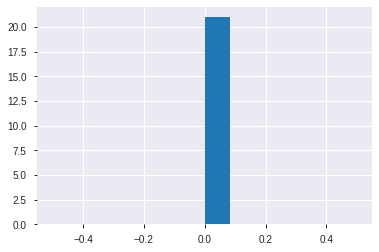

disruptionCost     int64
lostUnits          int64
totalProduction    int64
disruptedLinks     int64
activeLinks        int64
dtype: object

In [171]:
%matplotlib inline
import matplotlib.pyplot as plt
scenarioResults['disruptionCost'].astype(int).hist(bins=12)
plt.show()

scenarioResults.astype(int).dtypes

In [172]:
from pandas_profiling import ProfileReport
#print(pandas_profiling.__version__)

profile = ProfileReport(scenarioResults.astype(int), check_correlation = False)
profile

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,6
Number of observations,21
Total Missing (%),0.0%
Total size in memory,1.1 KiB
Average record size in memory,54.1 B
Numeric,2
Categorical,0
Boolean,1
Date,0
Text (Unique),1
Rejected,2
